# Visual Wake word detection

**Credit: [AITS Cainvas Community](https://discord.gg/x6xn39u)**

![](https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/visual_wake_word.gif)

*Photo by [LCR](https://dribbble.com/shots/3903645-Face-recognition) on [Dribbble](https://dribbble.com)*

Visual wake word detection is the classification of images into 2 classes - with person(s) or without. Just as audio wake word systems respond to a specific phrase, visual wake word systems respond to the presence of humans in the frame.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers, callbacks, optimizers
import keras 
import os
import random
from PIL import Image

# Dataset

The dataset is derived from [COCO 2017](https://cocodataset.org/#download) and reduced to 100mb using the script [here](https://gist.github.com/AyishaR/ccad108c6c5c4838833766ab63ad8bf7).

In [2]:
!wget -N https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/vww.zip

!unzip -qo vww.zip  

!rm vww.zip

--2020-12-29 11:33:08--  https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/vww.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.62.92
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.62.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95042991 (91M) [application/zip]
Saving to: ‘vww.zip’

vww.zip             100%[===================>]  90.64M  73.6MB/s    in 1.2s    

2020-12-29 11:33:09 (73.6 MB/s) - ‘vww.zip’ saved [95042991/95042991]



The dataset folder has two sub-folders - person and notperson containing images of respective types.

In [3]:
data_dir = 'vww/'

print("Number of samples")
for f in os.listdir(data_dir + '/'):
    if os.path.isdir(data_dir + '/' + f):
        print(f, " : ", len(os.listdir(data_dir + '/' + f +'/')))

Number of samples
notperson  :  300
person  :  300


It is a balanced dataset.

In [4]:
batch_size = 64

print("Training set")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=113, 
  batch_size=batch_size)

print("Validation set")
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=113, 
  batch_size=batch_size)

Training set
Found 600 files belonging to 2 classes.
Using 480 files for training.
Validation set
Found 600 files belonging to 2 classes.
Using 120 files for validation.


Define the class_names for use later.

In [5]:
class_names = train_ds.class_names
print(class_names)

['notperson', 'person']


# Visualization

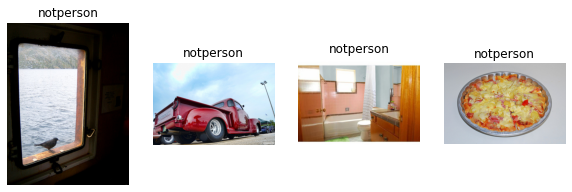

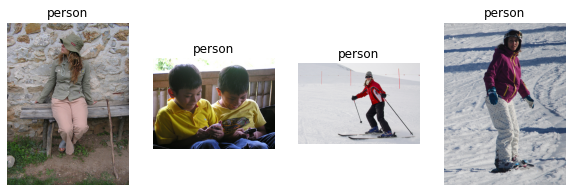

In [6]:
num_samples = 4    # the number of samples to be displayed in each class

for x in class_names:
    plt.figure(figsize=(10, 10))

    filenames = os.listdir(data_dir + x)

    for i in range(num_samples):
        ax = plt.subplot(1, num_samples, i + 1)
        img = Image.open(data_dir + x + '/' + filenames[i])
        plt.imshow(img)
        plt.title(x)
        plt.axis("off")

# Preprocessing

## Defining the input shape

In [7]:
print("Shape of one training batch")

for image_batch, labels_batch in train_ds:
    input_shape = image_batch[0].shape
    print("Input: ", image_batch.shape)
    print("Labels: ", labels_batch.shape)
    break

Shape of one training batch
Input:  (64, 256, 256, 3)
Labels:  (64,)


## Normalizing the pixel values

Pixel values are now integers between 0 and 255. Changing them to the range [0, 1] for faster convergence.

In [8]:
# Normalizing the pixel values

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# The model

Transfer learning

In [9]:
base_model = keras.applications.DenseNet121(weights= 'imagenet', input_shape=input_shape, include_top=False)    # False, do not include the classification layer of the model

base_model.trainable = False

inputs = tf.keras.Input(shape=input_shape)

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(len(class_names), activation = 'softmax')(x)    # Add own classififcation layer

model = keras.Model(inputs, outputs)

cb = [callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)]

In [10]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(0.01), metrics=['accuracy'])

history = model.fit(train_ds, validation_data =  val_ds, epochs=32, callbacks = cb)

Epoch 1/32
8/8 [==============================] - 6s 766ms/step - loss: 1.2594 - accuracy: 0.5938 - val_loss: 0.9825 - val_accuracy: 0.6000
Epoch 2/32
8/8 [==============================] - 3s 332ms/step - loss: 0.5092 - accuracy: 0.7729 - val_loss: 0.2708 - val_accuracy: 0.8917
Epoch 3/32
8/8 [==============================] - 3s 334ms/step - loss: 0.2093 - accuracy: 0.9208 - val_loss: 0.2419 - val_accuracy: 0.9250
Epoch 4/32
8/8 [==============================] - 3s 324ms/step - loss: 0.1656 - accuracy: 0.9208 - val_loss: 0.2645 - val_accuracy: 0.8750
Epoch 5/32
8/8 [==============================] - 3s 335ms/step - loss: 0.1312 - accuracy: 0.9458 - val_loss: 0.1953 - val_accuracy: 0.9333
Epoch 6/32
8/8 [==============================] - 3s 320ms/step - loss: 0.0979 - accuracy: 0.9688 - val_loss: 0.2056 - val_accuracy: 0.9500
Epoch 7/32
8/8 [==============================] - 3s 322ms/step - loss: 0.0812 - accuracy: 0.9792 - val_loss: 0.1974 - val_accuracy: 0.9500
Epoch 8/32
8/8 [====

In [11]:
model.evaluate(val_ds)

2/2 [==============================] - 0s 110ms/step - loss: 0.1953 - accuracy: 0.9333


[0.19531266391277313, 0.9333333373069763]

# Plotting the metrics

In [12]:
def plot(history, variable, variable2):
    plt.plot(range(len(history[variable])), history[variable])
    plt.plot(range(len(history[variable2])), history[variable2])
    plt.title(variable)

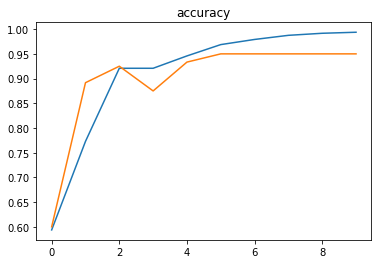

In [13]:
plot(history.history, "accuracy", 'val_accuracy')

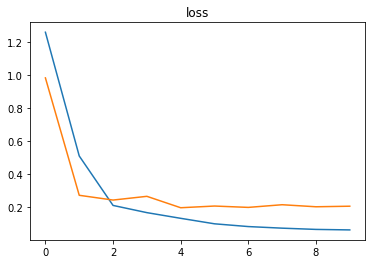

In [14]:
plot(history.history, "loss", "val_loss")

# Prediction

Predicted:  person
True:  notperson
Probability:  0.7615483


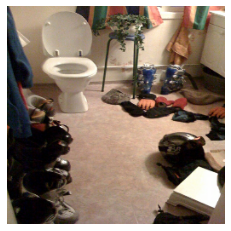

In [15]:
# pick random test data sample from one batch
x = random.randint(0, batch_size - 1)

for i in val_ds.as_numpy_iterator():
    img, label = i    
    plt.axis('off')   # remove axes
    plt.imshow(img[x])    # shape from (64, 256, 256, 3) --> (256, 256, 3)
    output = model.predict(np.expand_dims(img[x],0))    # getting output; input shape (256, 256, 3) --> (1, 256, 256, 3)
    pred = np.argmax(output[0])    # finding max
    print("Predicted: ", class_names[pred])    # Picking the label from class_names base don the model output
    print("True: ", class_names[label[x]])
    print("Probability: ", output[0][pred])
    break

# deepC

In [16]:
model.save('visual_wake_word.h5')

!deepCC vww.h5